<a href="https://colab.research.google.com/github/Spicyredd/Learn_PyTorch/blob/master/01_pytorch_workflow_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Workflow

Let's explore an example of PyTorch end-to-end workflow.

Resources:
* Ground truth notebook - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb
* Book version of notebook - https://www.learnpytorch.io/01_pytorch_workflow/
* Ask a question - https://github.com/mrdbourke/pytorch-deep-learning/discussions



In [1]:
what_we_are_covering = {
    1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions (inferencing) and evaluating a model",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [2]:
import torch
from torch import nn ## nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.6.0+cu124'

## 1. Data (Preparing and loading)

Data can be almost anything... in machine learning.

* Excel spreadsheet
* Images of any kind
* Videos (Youtube has lots of data...)
* Audio like songs or podcasts
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representations.
2. Build a model to learn patterns in that numerical representations.

To showcase this, let's create some **known** data using linear regression formula. We'll use a linear regression formula to make a straight line with **known parameters**

In [3]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

### Splitting data in training and test sets (one of the most important concepts in machine learning in general)

Let's create a training and test set with our data

In [5]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

This is where the data explorer's motto comes in!

"Visualize, visualize, visualize!"

In [108]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot train data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in gree
  plt.scatter(test_data, test_labels, c="g", s=4, label="Test data")

  # Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

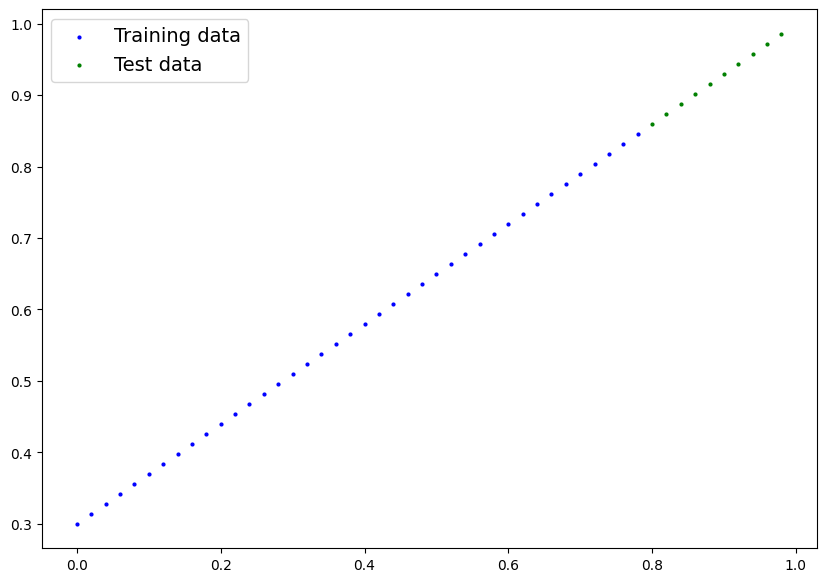

In [7]:
plot_predictions()

## 2. Build Model

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?

Through two main algorithms:
1. Gradient descent - https://youtu.be/IHZwWFHWa-w_
2. Backpropagation - https://youtu.be/Ilg3gGewQ5U

In [8]:
from torch import nn

# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost every thing in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, # start with a random weight and try to adjust it to the ideal weight
                                            requires_grad=True, # <- can this parameter be updated via gradient descent?
                                            dtype=torch.float)) # <- PyTorch loves the datatype torch. float32


    self.bias = nn.Parameter(torch.randn(1,  # start with a random weight and try to adjust it to the ideal weight
                                         requires_grad=True, # <- can this parameter be updated via gradient descent?
                                         dtype=torch.float)) # <- PyTorch loves the datatype torch. float32


  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias # linear regression

### PyTorch model building essentials

* torch.nn - contains all of the building blocks for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Paramter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this is where the optimizers in the PyTorch live. This will help with the gradient descent.
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computations

See more of these essential modules via the PyTorch cheatsheet - https://pytorch.org/tutorials/beginner/ptcheat.html

In [9]:
torch.manual_seed(42)
torch.randn(1)

tensor([0.3367])

### Checking the contents of our PyTorch model

Now we've created a model, let's see what's inside

In [10]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the odel (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [11]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check out model's predictive power, let's see how well it predicts `y_test` based on `X_test`

When we pass data through our model, it's going to run through the `forward()` method

In [12]:
# Make preditions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

# # You can also do something similar with torch.no_grad(), however, inference_mode() is preferred.
# with torch.no_grad():
#   y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

See more on - https://x.com/PyTorch/status/1437838231505096708?lang=en

In [13]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

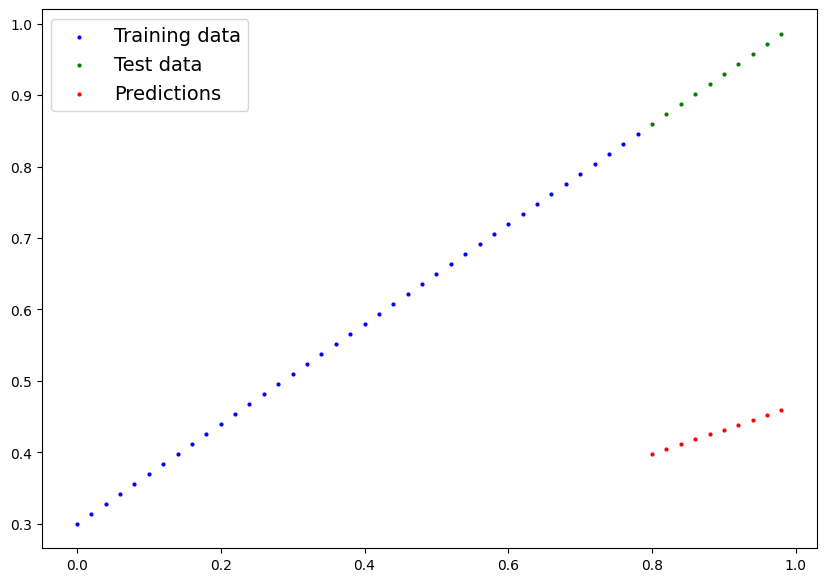

In [14]:
plot_predictions(predictions=y_preds)

## 3. Train Model

The whole idea of training is for a model to move from some *unknown* parameters (these maybe random) to some *known* parameters.

Or in another words from a poor representation of data to a good representation of data

One way to measure how poor or how wrong your model's prediction are you need to use a loss function

* Note: Loss function my also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

Things we need to train:

* **Loss function:** A function to measure how wrong your model's prediction are to the ideal outputs, lower is better

* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias in our case) to improve the loss function - https://docs.pytorch.org/docs/stable/optim.html

  * Inside th optimizer you'll often have to set two parameters:
    * `params`- the model parameters you'd like to optimize, for example `params=model_0.parameters()`
    * `lr` (learning rate) - the learning rate is a hyperparameter that defines how big/small the optimizer changes the parameters with each step (a small `lr` results in small changes, a large `lr` results in large changes)

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [15]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [16]:
# Check out our model's parameters (a parameter is a value that the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [17]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # lr = learning rate = possibly the most important hyperparameter you can set

**Q:** Which loss function and optimizer should I use?

**A:** This will be problem specific. But with experience, you'll get an idea of what workd and what doesn't with your particular problem set.

For example, for a regression problem (like ours), a loss of `nn.L1Loss()` and an optimizer like `torch.optim.SGD()` will suffice.

But for a classification problem like classifying whether a photo is of a dog or a cat, you'll likely want to use a loss function of `nn.BCELOSS()` (binary cross entropy loss).

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwords through the neural network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve our loss.(**gradient descent**)

In [18]:
with torch.no_grad():
  list(model_0.parameters())

In [19]:
list(model_0.eval().parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [20]:
torch.manual_seed(42)

# An epoch is one loop through the data... (this is a hyperparameter because we've set it ourselves)
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameter of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will acculumate through the loop so... we have to zero them above step 3 for the next iteration of the loop

  model_0.eval() # turns off the gradient tracking
  with torch.inference_mode(): # turns off gradient tracking & a couple more thing behind the scenes
  # with torch.no_grad(): # you may also see torch.no_grad() in older PyTorch code
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happenin`
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test_loss: {test_loss}")

    # Print out model state_dict()
    print(model_0.state_dict()) # turns off different settings in the model not needed for evaluation/testing (dropout/batch norm layers)

Epoch: 0 | Loss: 0.31288138031959534 | Test_loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test_loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test_loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test_loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test_loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test_loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test_loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

In [21]:
import numpy as np
np.array(torch.tensor(loss_values).numpy())

array([0.31288138, 0.19767132, 0.08908726, 0.05314853, 0.04543797,
       0.04167863, 0.03818933, 0.0347609 , 0.03132383, 0.0278874 ,
       0.02445896, 0.02102021, 0.01758547, 0.01415539, 0.01071659,
       0.00728353, 0.00385178, 0.00893248, 0.00893248, 0.00893248],
      dtype=float32)

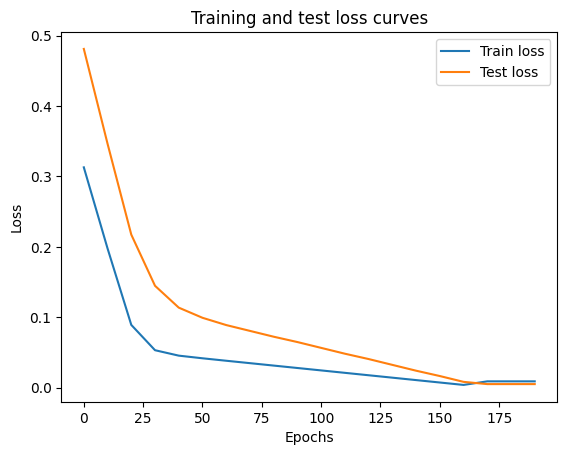

In [22]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [23]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

In [24]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [25]:
weight, bias

(0.7, 0.3)

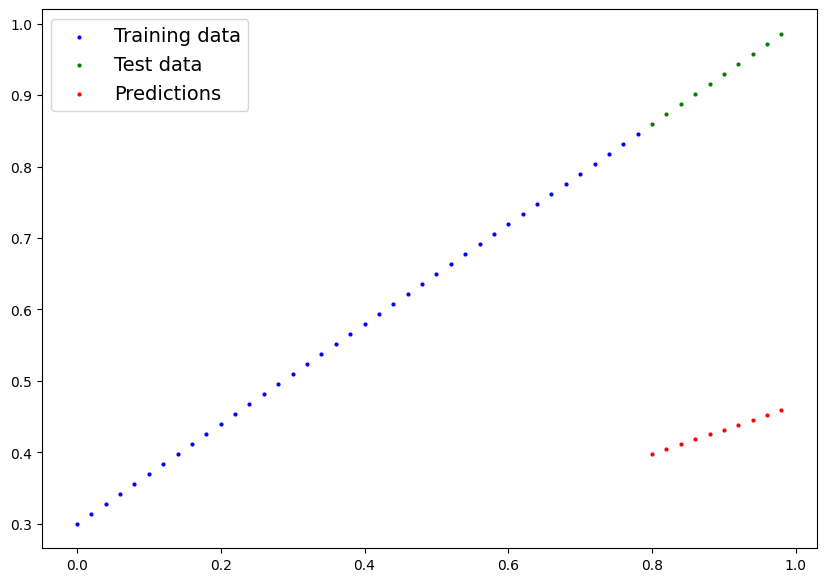

In [26]:
plot_predictions(predictions=y_preds)

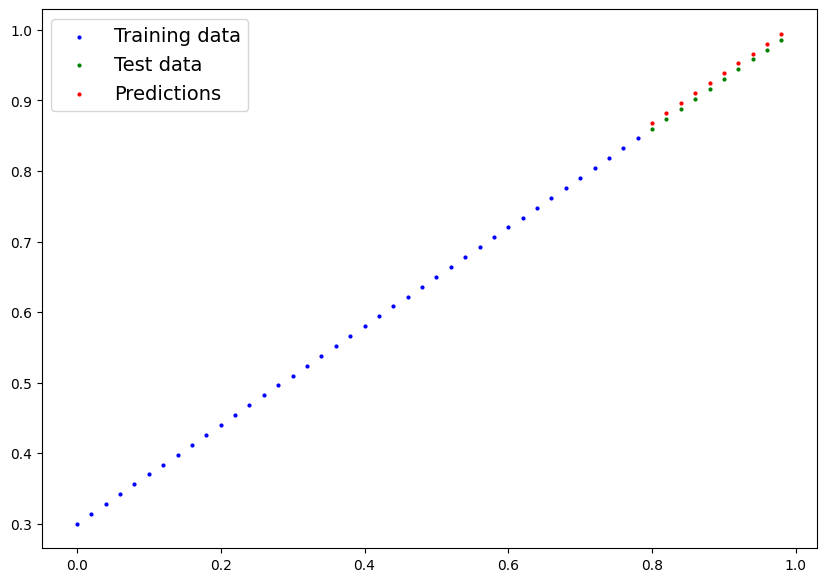

In [27]:
plot_predictions(predictions = y_preds_new)

## Saving a model in PyTorch

There are three main methods you should know about for saving and loading models in PyTorch.

1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you to save a PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary

PyTorch save & load code tutorial + extra-curriculum - https://docs.pytorch.org/tutorials/beginner/saving_loading_models.html

In [31]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [32]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1680 May 17 11:00 01_pytorch_workflow_model_0.pth


### Why save the state_dict only instead of the entire model?

Because saving the entire model rather save the path to the file containing the class, which is used during load time because of this the code can break.

## Loading a PyTorch model

Since we saved our model's `state_dict` rather than the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that.

In [61]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [62]:
# To load in a saved_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
with torch.inference_mode():
  y_pred = loaded_model_0(X_test)

In [63]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [64]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)
loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [65]:
# Compare loaded model preds with original model preds
model_0.eval()
with torch.inference_mode():
  y_pred = model_0(X_test)

y_pred == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

Let's go back throught the steps above and see it all in one place.

In [1]:
# Importing PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [13]:
X = torch.tensor([np.random.randint(1,50) for x in range(51)]).unsqueeze(dim=1)
# y = 4*X*X + 5*X + 6

split = 40
X_train = X[:40]
y_train = y[:40]
X_test = X[40:]
y_test = y[40:]

In [46]:
class AreaOfCircle(nn.Module):
  def __init__(self):
    super().__init__()
    self.pi = nn.Parameter(torch.randn(1,
                                  requires_grad=True,
                                  dtype=torch.float))

  def forward(self, x):
    return self.pi * x * x

In [49]:
torch.manual_seed(42)
model = AreaOfCircle()
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01)

# Get initial state of model
with torch.inference_mode():
  y_pred_initial = torch.tensor(model(y_test)).numpy()

<ipython-input-49-c1e01fc96bd3>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_initial = torch.tensor(model(y_test)).numpy()


In [50]:
model.state_dict()

OrderedDict([('pi', tensor([0.3367]))])

In [51]:
epochs = 401
for epoch in range(epochs):
  model.train()

  y_pred = model(X_train)
  loss = loss_fn(y_pred, y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model.eval()

  with torch.inference_mode():
    y_pred = model(X_test)
    test_loss = loss_fn(y_pred, y_test)
  if epoch % 10 == 0:
    print(f"Epoch: {epoch}")
    print(f'Train loss: {loss}, Test loss: {test_loss}, Model State:{model.state_dict()}')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 0
Train loss: 2147.345703125, Test loss: 2999.48486328125, Model State:OrderedDict([('pi', tensor([3.0187]))])
Epoch: 10
Train loss: 2454.062255859375, Test loss: 6459.81982421875, Model State:OrderedDict([('pi', tensor([6.9952]))])
Epoch: 20
Train loss: 2447.804931640625, Test loss: 6469.04150390625, Model State:OrderedDict([('pi', tensor([7.0039]))])
Epoch: 30
Train loss: 2449.398681640625, Test loss: 6466.69091796875, Model State:OrderedDict([('pi', tensor([7.0017]))])
Epoch: 40
Train loss: 2450.992431640625, Test loss: 6464.3427734375, Model State:OrderedDict([('pi', tensor([6.9995]))])
Epoch: 50
Train loss: 2452.5869140625, Test loss: 6461.99365234375, Model State:OrderedDict([('pi', tensor([6.9973]))])
Epoch: 60
Train loss: 2458.245849609375, Test loss: 6453.654296875, Model State:OrderedDict([('pi', tensor([6.9895]))])
Epoch: 70
Train loss: 2186.414306640625, Test loss: 3173.01416015625, Model State:OrderedDict([('pi', tensor([3.4031]))])
Epoch: 80
Train loss: 3012.195068

In [33]:
# Plot training data and compare predictions
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10,7))

  # Plot train data
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")

  # Plot test data
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing Data")

  # Plot predictions
  if predictions is not None:
    print(test_data.shape, predictions.shape)
    plt.scatter(test_data, predictions, c="red", s=4, label="Predictions")

torch.Size([11, 1]) (11,)


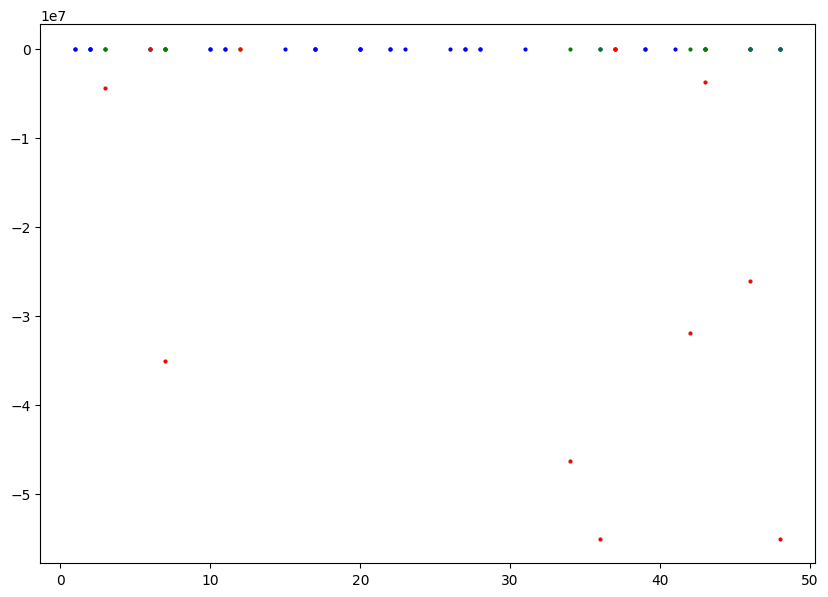

In [30]:
# Plot the initial state of model
plot_predictions(predictions = y_pred_initial)

torch.Size([11, 1]) (11,)


<ipython-input-52-72c55da580ea>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = torch.tensor(model(y_test)).numpy()


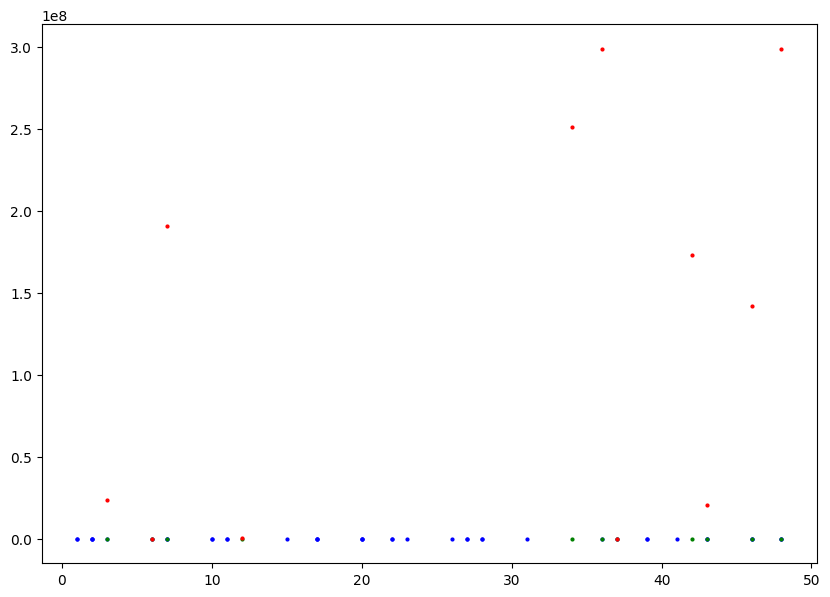

In [52]:
# Plot after state of model
with torch.inference_mode():
  y_pred = torch.tensor(model(y_test)).numpy()
plot_predictions(predictions = y_pred)

## 6. Putting it all together

Let's go back through the steps above and see it all in one place

In [11]:
# Import PyTorch model and other libraries
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.6.0+cu124'

Create diagnostic code.

This means if we've got access to a GPU, our code will use it (for potentially faster computing).

If no GPU is available, the code will default to using CPU.

In [12]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using device: {device}')

Using device: cpu


### 6.1 Data

In [88]:
# Create some data using the linear regression formula of y = weight * X + bias

weight = 0.5
bias = 0.1

# Create a range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).to(device).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.1000],
         [0.1100],
         [0.1200],
         [0.1300],
         [0.1400],
         [0.1500],
         [0.1600],
         [0.1700],
         [0.1800],
         [0.1900]]))

In [54]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

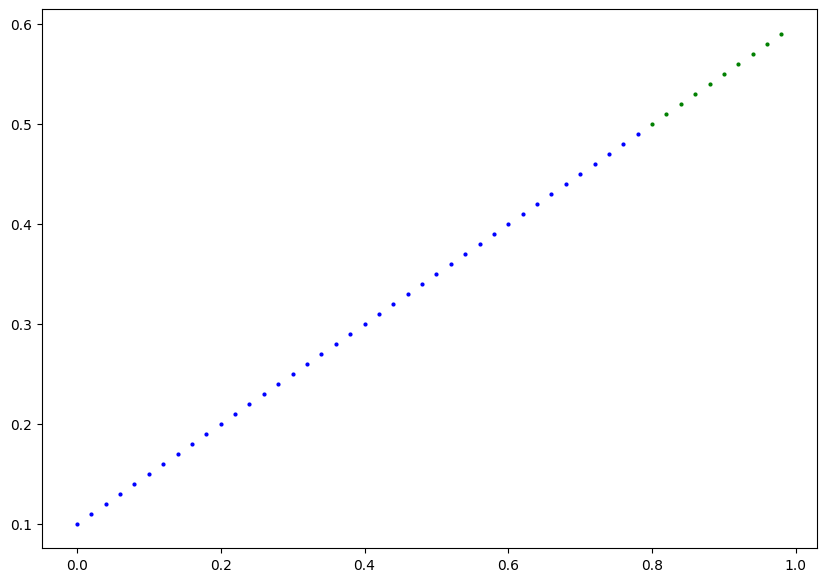

In [56]:
# Plot the data
# Note: if you don't have the plot_predictions() function loaded, this will error
plot_predictions(X_train, y_train, X_test, y_test)

### 6.2 Building a PyTorch Linear Model

In [96]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters / also called: linear transform, probing layer, fully connected layer, dense layer
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.linear_layer(x)
    return x

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [97]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [98]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

In [99]:
# Setup loss function
loss_fn = nn.L1Loss() # same as MAE

# Setup optimizer
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=0.01)

### 6.3 Training

For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [100]:
# Let's write a training loop
torch.manual_seed(42)

epochs = 200

for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. zero_grad() the optimizer
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Step optimizer
  optimizer.step()

  ### Testing
  model.eval()
  with torch.inference_mode():
    test_pred = model_1(y_test)
    test_loss = loss_fn(test_pred, y_test)
  if epoch % 10 == 0:
    print(f"Epoch: {epoch}")
    print(f"Loss: {loss}, Test loss: {test_loss}")

Epoch: 0
Loss: 0.833177924156189, Test loss: 0.6895558834075928
Epoch: 10
Loss: 0.7179681062698364, Test loss: 0.5683010816574097
Epoch: 20
Loss: 0.6027581095695496, Test loss: 0.4470461905002594
Epoch: 30
Loss: 0.487548291683197, Test loss: 0.3257913291454315
Epoch: 40
Loss: 0.3723384439945221, Test loss: 0.20453648269176483
Epoch: 50
Loss: 0.2571285367012024, Test loss: 0.08328162133693695
Epoch: 60
Loss: 0.14191867411136627, Test loss: 0.037973277270793915
Epoch: 70
Loss: 0.026708656921982765, Test loss: 0.15922829508781433
Epoch: 80
Loss: 0.005493368022143841, Test loss: 0.18033041059970856
Epoch: 90
Loss: 0.005493368022143841, Test loss: 0.18033041059970856
Epoch: 100
Loss: 0.005493368022143841, Test loss: 0.18033041059970856
Epoch: 110
Loss: 0.005493368022143841, Test loss: 0.18033041059970856
Epoch: 120
Loss: 0.005493368022143841, Test loss: 0.18033041059970856
Epoch: 130
Loss: 0.005493368022143841, Test loss: 0.18033041059970856
Epoch: 140
Loss: 0.005493368022143841, Test loss:

In [101]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.4923]])),
             ('linear_layer.bias', tensor([0.1085]))])

In [102]:
weight, bias

(0.5, 0.1)

### 6.4 Making and evaluating predictions

In [106]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[0.5023],
        [0.5122],
        [0.5220],
        [0.5319],
        [0.5417],
        [0.5516],
        [0.5614],
        [0.5712],
        [0.5811],
        [0.5909]])

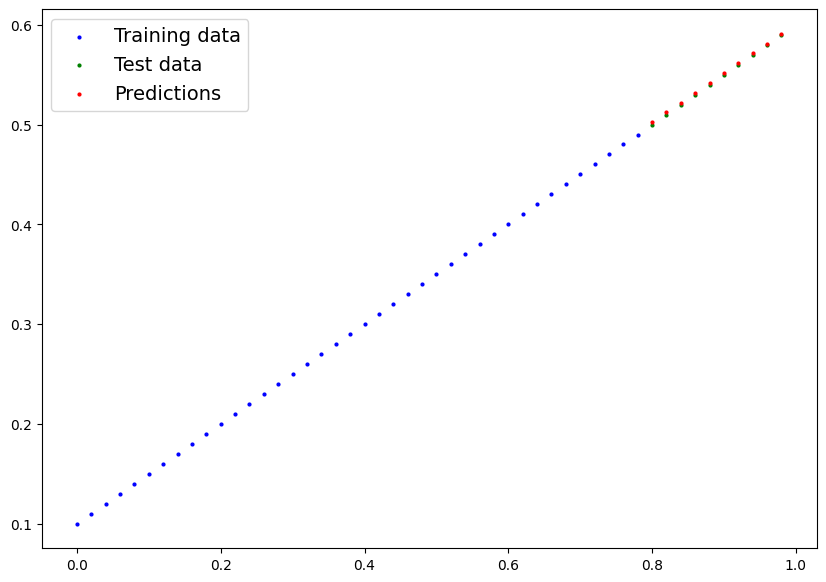

In [110]:
# Check out our model's prediction visually
plot_predictions(predictions=y_preds)

### 6.5 Saving & loading a trained model

In [113]:
from pathlib import Path

# Defining paths
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create a model save path
MODEL_NAME = "LinearRegressionModelV2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
torch.save(obj=model_1.state_dict(),f= MODEL_SAVE_PATH)

In [117]:
# Load a PyTorch model

# Create a new instance of linear regression model V2
model_2 = LinearRegressionModelV2()

# Load the saved model_1 state_dict
model_2.load_state_dict(torch.load(MODEL_SAVE_PATH))

model_2.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [120]:
next(model_2.parameters()).device

device(type='cpu')

In [121]:
model_2.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.4923]])),
             ('linear_layer.bias', tensor([0.1085]))])

In [122]:
# Evaluate the model
model_2.eval()
with torch.inference_mode():
  model_2_preds = model_2(X_test)
y_preds == model_2_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])